# Credit Risk Models
Analyzing a credit dataset using three models to estimate PDs: Logit, ANN and KNN.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
import itertools

## Analyzing the dataset

#### I - Auxiliar functions

In [4]:
#Auxiliar functions: to make association graphs between variables
def ratio(df,feature,target):
    target_cl=[1,0]
    feature_cl=pd.get_dummies(df[feature]).columns.tolist()
    d1=pd.DataFrame(index=feature_cl,columns=['Approved','Rejected','weight'])
    for i in feature_cl:
        weight=len(df[df[feature]==i])/len(df[feature])
        d1['weight'].loc[i]=weight*100
        d1['Approved'].loc[i]=100*len(df[(df[feature]==i) & (df[target]==target_cl[0])])/len(df[df[feature]==i])
        d1['Rejected'].loc[i]=100*len(df[(df[feature]==i) & (df[target]==target_cl[1])])/len(df[df[feature]==i])
    return d1

def num_ratio(df,feature,target,clust):
    d=pd.DataFrame(index=clust ,columns=['Approved','Rejected','Weight'])
    
    for i in range(len(clust)):
        d['Weight'].iloc[i]=100*len(df[df[feature].between(clust[i][0],clust[i][1])])/len(df)
        d['Approved'].iloc[i]=100*len(df[(df[feature].between(clust[i][0],clust[i][1])) & (df[target]==1)])/len(df[df[feature].between(clust[i][0],clust[i][1])])
        d['Rejected'].iloc[i]=100*len(df[(df[feature].between(clust[i][0],clust[i][1])) & (df[target]==0)])/len(df[df[feature].between(clust[i][0],clust[i][1])])
    return d

#### II - Data visualization

In [5]:
#Import the data
data_ex2=pd.read_excel('credit_data_ex2.xlsx')

In [6]:
#Insepcting and dropping Missing Valus
data_ex2.info()
data_ex2.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           677 non-null    object 
 1   Age              677 non-null    float64
 2   Debt             689 non-null    float64
 3   Marital Status   683 non-null    object 
 4   Bank Customer    683 non-null    object 
 5   Education level  680 non-null    object 
 6   Etnicity         680 non-null    object 
 7   Years employed   689 non-null    float64
 8   Prior default    689 non-null    object 
 9   Employed         689 non-null    object 
 10  Credit score     689 non-null    int64  
 11  Drivers license  689 non-null    object 
 12  Citizen          689 non-null    object 
 13  ZIP Ccode        676 non-null    float64
 14  Income           689 non-null    int64  
 15  Approved         689 non-null    int64  
dtypes: float64(4), int64(3), object(9)
memory usage: 86.2+ KB


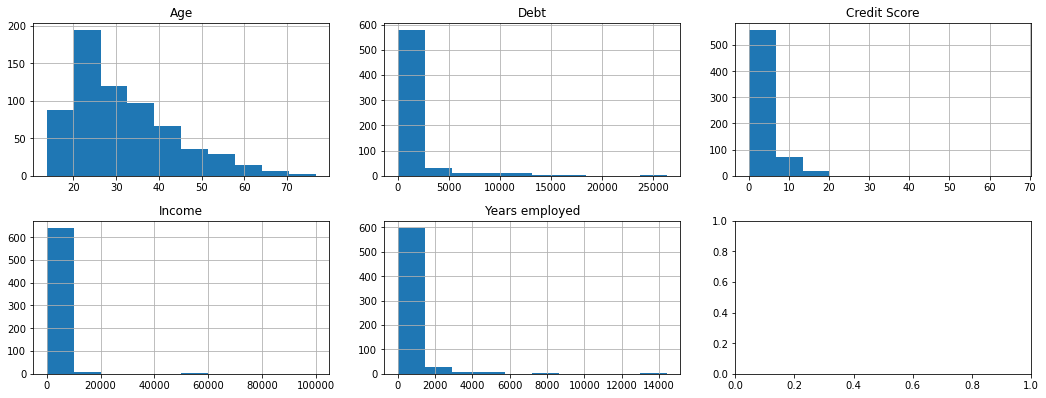

In [7]:
#Plot Histograms
fig,ax=plt.subplots(2,3, figsize=(15,6))
ax[0,0].set_title('Age')
ax[0,0]=data_ex2['Age'].hist(ax=ax[0,0])
ax[0,1].set_title('Debt')
ax[0,1]=data_ex2['Debt'].hist(ax=ax[0,1])
ax[0,2].set_title('Credit Score')
ax[0,2]=data_ex2['Credit score'].hist(ax=ax[0,2])
plt.tight_layout(pad=2.4)
ax[1,0].set_title('Income')
ax[1,0]=data_ex2['Income'].hist(ax=ax[1,0])
ax[1,1].set_title('Years employed')
ax[1,1]=data_ex2['Years employed'].hist(ax=ax[1,1])

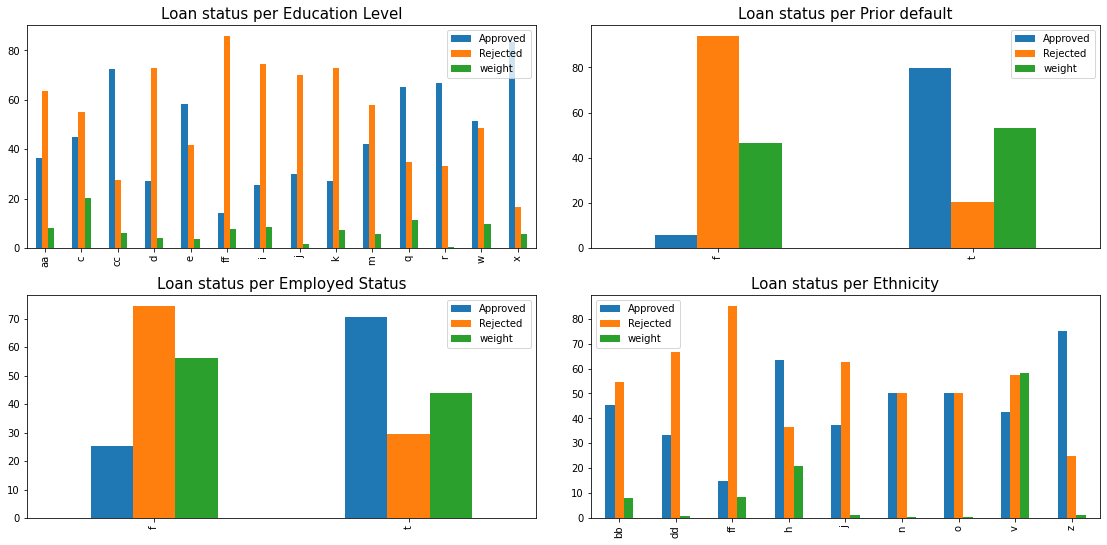

In [8]:
#Comparison between variables
fig,ax=plt.subplots(2,2, figsize=(16,8))

ax[0,0].set_title('Loan status per Education Level',fontsize=15)
ax[0,0]=ratio(data_ex2,'Education level','Approved').plot(kind='bar',ax=ax[0,0])

ax[0,1].set_title('Loan status per Prior default',fontsize=15)
ax[0,1]=ratio(data_ex2,'Prior default','Approved').plot(kind='bar',ax=ax[0,1])

plt.tight_layout(pad=2.4)
ax[1,0].set_title('Loan status per Employed Status',fontsize=15)
ax[1,0]=ratio(data_ex2,'Employed','Approved').plot(kind='bar',ax=ax[1,0])

ax[1,1].set_title('Loan status per Ethnicity',fontsize=15)
ax[1,1]=ratio(data_ex2,'Etnicity','Approved').plot(kind='bar',ax=ax[1,1])

plt.show()

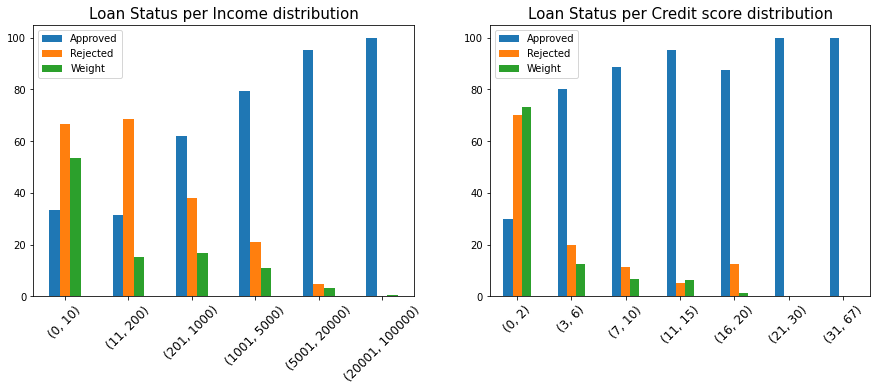

In [9]:
fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('Loan Status per Income distribution',fontsize=15)
num_ratio(data_ex2,'Income','Approved',[(0,10),(11,200),(201,1000),(1001,5000),(5001,20000),(20001,100000)]).plot(kind='bar',ax=ax[0])
ax[0].set_xticklabels([(0,10),(11,200),(201,1000),(1001,5000),(5001,20000),(20001,100000)],rotation=45, fontsize=12)

ax[1].set_title('Loan Status per Credit score distribution',fontsize=15)
num_ratio(data_ex2,'Credit score','Approved',[(0,2),(3,6),(7,10),(11,15),(16,20),(21,30),(31,67)]).plot(kind='bar',ax=ax[1])
ax[1].set_xticklabels([(0,2),(3,6),(7,10),(11,15),(16,20),(21,30),(31,67)],rotation=45, fontsize=12)

plt.show()

## Data Cleaning

#### I - Auxiliar functions

In [13]:
#Auxiliar function: normalization of the data
def normalize(data):
    return (data-np.min(data))/ (np.max(data)-np.min(data))

#Auxiliar function: Confusion Matrix
def conf_matrix(y_preds,y_true):
    c=np.array([[0,0],[0,0]])
    
    c[0,0]=len(y_preds[(y_preds==0)&(y_true==0)])
    c[0,1]=len(y_preds[(y_preds==0)&(y_true==1)])
    c[1,0]=len(y_preds[(y_preds==1)&(y_true==0)])
    c[1,1]=len(y_preds[(y_preds==1)&(y_true==1)])
    
    return c

#Auxiliar function: ROC curve
def roc(y_probs,y_true):
    thresholds=np.arange(0,1.01,0.01)
    roc_df=pd.DataFrame(columns=['Sensitivity','1-Specificity'],index=thresholds)
    for t in thresholds:
        y_preds=np.zeros_like(y_probs)
        y_preds[y_probs<t]=1
        c=conf_matrix(y_preds,y_true)
        
        roc_df['Sensitivity'].loc[t]=(c[0,0]/np.sum(c[:,0]))*100
        roc_df['1-Specificity'].loc[t]=(1-c[1,1]/np.sum(c[:,1]))*100
    
    return roc_df

#Auxiliar function: IV computation
def iv(df,feature,target):
    target_cl=[1,0]
    feature_cl=list(df[feature].unique())
    iv=0
    for i in feature_cl:
        if len(df[(df[target]==target_cl[0])&(df[feature]==i)])==0 or len(df[(df[target]==target_cl[1])&(df[feature]==i)])==0:
            pass
        
        else:
            a=len(df[(df[target]==target_cl[0])&(df[feature]==i)])/len(df[df[target]==target_cl[0]])
            b=len(df[(df[target]==target_cl[1])&(df[feature]==i)])/len(df[df[target]==target_cl[1]])

            woe=np.log(a/b)
            iv+=(a-b)*woe
    return iv


#Auxiliar function: alghoritm for calculating the optimal combination of variables using an iterative process
def opt_variables(X,y,n):
    #All combinatios of variables
    comb=list(itertools.combinations(X.columns.tolist(), n))
    
    acc=[]
    for i in comb:
        X_=X[list(i)].copy()

        model = LogisticRegression(max_iter=800)
        model.fit(X_,y)

        #Predicting high risk applicants
        probs = model.predict_proba(X_)[:,0]

        #Predict classes
        preds=np.zeros_like(probs)
        preds[probs<0.5]=1
        
        acc.append(len(preds[preds==y])/len(y))
        
        
    df=pd.DataFrame({'Accuracy':acc},index=comb)
    
    return (df.iloc[df['Accuracy'].argmax()].name , df['Accuracy'].max())

#### II -  Clean and split

In [14]:
num_variables=['Age','Debt','Years employed','Credit score','Income']
cat_variables=['Gender','Marital Status','Bank Customer','Education level',
             'Etnicity','Prior default','Employed',
              'Drivers license','Citizen']

n_data=data_ex2.copy()

#Normalize continuous variables
for col in num_variables:
    n_data[col]=normalize(data_ex2[col])
    
#Convert categorical variables to integers
for col in cat_variables: 
    n_data[col]=data_ex2[col].astype('category').cat.codes


#Train-test split
X_train, X_test, y_train, y_test = train_test_split(n_data[n_data.columns[:-1]],
                                                    n_data['Approved'],
                                                    test_size=0.35,random_state=101)

#### III - Variables selection criteria

In [15]:
#Calculating IV for the train set
ex2_iv=pd.DataFrame(index=n_data.columns[:-1],columns=['IV'])
for col in ex2_iv.index:
    ex2_iv['IV'].loc[col]=iv(n_data.loc[y_train.index],col,'Approved')
    
ex2_iv.sort_values(by='IV',ascending=False)

,IV
Prior default,2.95711
Credit score,0.846866
Education level,0.671683
Employed,0.662435
Years employed,0.446025
Etnicity,0.407912
ZIP Ccode,0.395705
Debt,0.387227
Income,0.319935
Age,0.0946675


In [16]:
#Computing the best combination of variables using iterative algorithm
dic={}
for i in tqdm(range(1,len(n_data.columns[:-1])+1 )):
    c=opt_variables(X_train,y_train,i)
    dic[c[0]]=c[1]

In [17]:
#Criteria for selecting variables

#Model 1 (0.1<IV<0.5)
m_1=ex2_iv[(ex2_iv.IV>0.1) & (ex2_iv.IV<0.5)].index.tolist()


#Model 2 (IV>0.1)
m_2=ex2_iv[(ex2_iv.IV>0.1)].index.tolist()

#Model 3 (algorithm)
m_3=list(list(dic.keys())[np.argmax(list(dic.values()))])

## Logit Model

In [18]:
criteria=m_2.copy()

#Logit model
logmodel = LogisticRegression(max_iter=800)
logmodel.fit(X_train[criteria],y_train)

#Predict PD (rejected)
log_p = logmodel.predict_proba(X_test[criteria])[:,0]

#Predict classes
log_preds=np.zeros_like(log_p)
log_preds[log_p<0.5]=1


Logit Confussion Matrix
[[109   7]
 [ 21  92]]
Accuracy: 0.8777292576419214 Sensitivity: 0.84 Specificity: 0.93


Text(0, 0.5, 'Sensitivity (%)')

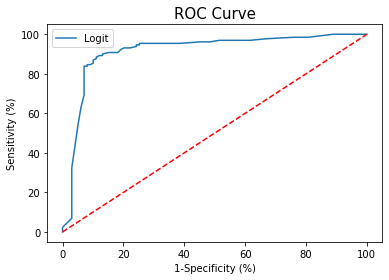

In [19]:
#Confusion matrix for Logit
print('\nLogit Confussion Matrix')
log_cmatrix=conf_matrix(log_preds,y_test)
print(log_cmatrix)
print('Accuracy:',(log_cmatrix[0,0]+log_cmatrix[1,1])/np.sum(log_cmatrix),
     'Sensitivity:',round(log_cmatrix[0,0]/np.sum(log_cmatrix[:,0]),2),
     'Specificity:',round(log_cmatrix[1,1]/np.sum(log_cmatrix[:,1]),2))


#ROC Curve plot for Logit
log_roc=roc(log_p,y_test)
plt.plot(log_roc['1-Specificity'],log_roc['Sensitivity'],label='Logit')
plt.plot([0, 100], [0, 100],'r--')
plt.title('ROC Curve',fontsize=15)
plt.legend(loc=0)
plt.xlabel('1-Specificity (%)')
plt.ylabel('Sensitivity (%)')

## ANN Model

In [20]:
#ANN Model
model = Sequential()
model.add(Dense(units=X_train[criteria].shape[1],activation='sigmoid'))
model.add(Dense(units=X_train[criteria].shape[1],activation='relu'))
model.add(Dense(units=X_train[criteria].shape[1],activation='tanh'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
np.random.seed(1)
model.fit(X_train[criteria].values, y_train.values, epochs=100,batch_size=64,verbose=0,shuffle=False)
    
#Predict PD (rejected)
ann_p = 1-model.predict(X_test[criteria].values).flatten()
ann_preds=np.zeros_like(ann_p)

#Predict classes
ann_preds[ann_p<0.5]=1


ANN Confussion Matrix
[[115   9]
 [ 15  90]]
Accuracy: 0.8951965065502183 Sensitivity: 0.88 Specificity: 0.91


Text(0, 0.5, 'Sensitivity (%)')

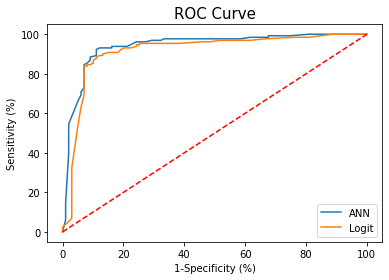

In [21]:
#Confusion matrix of ANN
print('\nANN Confussion Matrix')
ann_cmatrix=conf_matrix(ann_preds,y_test)
print(ann_cmatrix)
print('Accuracy:',(ann_cmatrix[0,0]+ann_cmatrix[1,1])/np.sum(ann_cmatrix),
     'Sensitivity:',round(ann_cmatrix[0,0]/np.sum(ann_cmatrix[:,0]),2),
     'Specificity:',round(ann_cmatrix[1,1]/np.sum(ann_cmatrix[:,1]),2))


#ROC Curve plot for both models
ann_roc=roc(ann_p,y_test)
plt.plot(ann_roc['1-Specificity'],ann_roc['Sensitivity'],label='ANN')
plt.plot(log_roc['1-Specificity'],log_roc['Sensitivity'],label='Logit')
plt.plot([0, 100], [0, 100],'r--')
plt.title('ROC Curve',fontsize=15)
plt.legend(loc=0)
plt.xlabel('1-Specificity (%)')
plt.ylabel('Sensitivity (%)')

## KNN Model

In [22]:
#Test-train split (same seed)
var=['Debt','Years employed','Credit score','Income']
X_tr, X_te, y_tr, y_te = train_test_split(n_data[var],
                                            n_data['Approved'],
                                            test_size=0.35,random_state=101)


Text(0, 0.5, 'Error Rate')

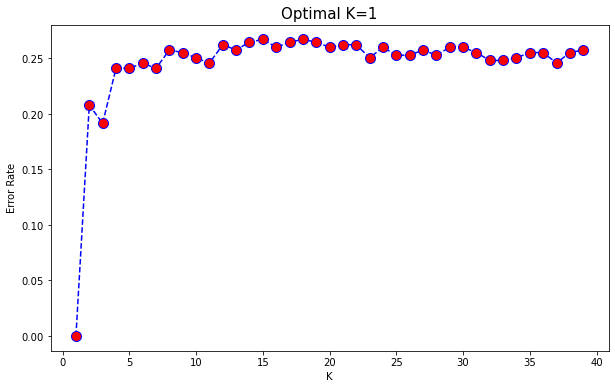

In [23]:
#KNN: Finding the optimal K in the train set
error_rate=[]
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_tr,y_tr)
    pred_i = knn.predict(X_tr)
    error_rate.append(np.mean(pred_i != y_tr))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Optimal K='+str(np.argmin(error_rate)+1),fontsize=15)
plt.xlabel('K')
plt.ylabel('Error Rate')

In [24]:
#Implementing KNN with K=1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_tr,y_tr)

#Predicting PD (rejected)
knn_p = knn.predict_proba(X_te)[:,0]

#Predicting Classes
knn_preds=np.zeros_like(knn_p)
knn_preds[knn_p<0.5]=1

In [25]:
#Evaluating KNN performance
print('\nKNN Confussion Matrix')
knn_cmatrix=conf_matrix(knn_preds,y_te)
print(knn_cmatrix)
print('Accuracy:',(knn_cmatrix[0,0]+knn_cmatrix[1,1])/np.sum(knn_cmatrix),
     'Sensitivity:',round(knn_cmatrix[0,0]/np.sum(knn_cmatrix[:,0]),2),
     'Specificity:',round(knn_cmatrix[1,1]/np.sum(knn_cmatrix[:,1]),2))


KNN Confussion Matrix
[[94 28]
 [36 71]]
Accuracy: 0.7205240174672489 Sensitivity: 0.72 Specificity: 0.72
